In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [2]:
spark = (
  SparkSession.builder
    .appName("Codeway")
    .master("local[*]")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/27 22:03:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Load the Model

In [3]:
from pyspark.ml import PipelineModel

bestUserModel = PipelineModel.load("/Users/macbookpro/PyCharmMiscProject/models/user_ltv_model")

# Read the Dataframe

In [4]:
# re-load the static preds
userPreds = spark.read.parquet("/Users/macbookpro/PyCharmMiscProject/Output_Dataframes/user_preds.parquet")
userPreds = userPreds.drop("season_vec", "country_vec", "operating_system_vec")

In [16]:
userPreds.printSchema()

root
 |-- auto_renew_off: long (nullable = true)
 |-- avg_event_hour: double (nullable = true)
 |-- country: string (nullable = true)
 |-- first_year_revenue: double (nullable = true)
 |-- free_trial: long (nullable = true)
 |-- operating_system: string (nullable = true)
 |-- paywall: long (nullable = true)
 |-- refund: long (nullable = true)
 |-- renewal: long (nullable = true)
 |-- season: string (nullable = true)
 |-- stickiness_ratio: double (nullable = true)
 |-- subscribe: long (nullable = true)
 |-- total_revenue: double (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_index: integer (nullable = true)
 |-- operating_system_idx: double (nullable = true)
 |-- country_idx: double (nullable = true)
 |-- season_idx: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- pred15: double (nullable = true)
 |-- forecast_1y: double (nullable = true)



In [5]:
from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressionModel
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
test = spark.read.json("/Users/macbookpro/PyCharmMiscProject/test_set/user_test_set")

# User-level Feature Importance

In [7]:
# ——— Load saved pipelines ———
bestModel = PipelineModel.load("/Users/macbookpro/PyCharmMiscProject/models/user_ltv_model")

In [8]:
bestModel.transform(test.limit(1)).select("features").printSchema()

root
 |-- features: vector (nullable = true)



In [9]:
# pull out the GBT stage
gbt = next(s for s in bestModel.stages
                if isinstance(s, GBTRegressionModel))

# Use the test set
feat_df = bestModel.transform(test.limit(1)).select("features")

# Read feature names from metadata
meta = feat_df.schema["features"].metadata
attrs = meta["ml_attr"]["attrs"]
# flatten all attr groups (numeric, binary, etc.)
feature_names = [item["name"] for group in attrs.values() for item in group]

# Get importances
importances = gbt.featureImportances.toArray().tolist()

assert len(feature_names) == len(importances), "Lengths still mismatch!"

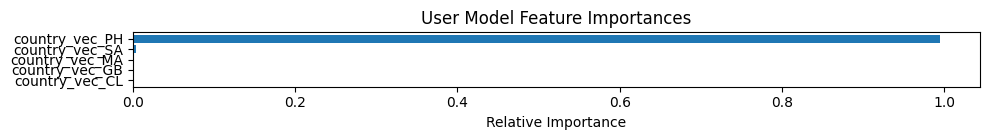

In [10]:
# 1) Pair names & importances safely
pairs = list(zip(feature_names, importances))

# 2) Build the DataFrame
df_fi = pd.DataFrame(pairs, columns=["feature", "importance"])

# 3) Filter out zeros and sort
df_fi = (
    df_fi[df_fi["importance"] > 0]
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

# 4) Extract for plotting
feat = df_fi["feature"].tolist()
imp  = df_fi["importance"].tolist()

# 5) Compute figure height dynamically
num_feats       = len(feat)
height_per_feat = 0.3  # inch per feature, tweak as needed
fig_height      = num_feats * height_per_feat

# 6) Plot all features
plt.figure(figsize=(10, fig_height))
plt.barh(feat[::-1], imp[::-1])
plt.title("User Model Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

Note that the Feature Importance is shown for the ones that are > 0

# User-level Residuals & Deciles

In [11]:
from pyspark.sql.window import Window
from pyspark.storagelevel import StorageLevel

In [12]:
# Unpersist cached old DF so Spark forgets those part-files
try:
    userPreds.unpersist()
except NameError:
    pass

# Re-load the cohortPreds DataFrame from disk (fresh, uncached)
userPreds = spark.read.parquet(
    "/Users/macbookpro/PyCharmMiscProject/Output_Dataframes/user_preds.parquet"
)

# Cache it again for speed
userPreds = userPreds.persist(StorageLevel.MEMORY_AND_DISK)

In [13]:
# Compute residuals
res = (userPreds
       .withColumn("residual", F.col("pred15") - F.col("total_revenue"))
      )

# Summary statistics
res.select(
    F.avg("residual").alias("mean_residual"),
    F.stddev("residual").alias("std_residual"),
    F.expr("percentile_approx(residual, 0.5)").alias("median_residual"),
).show(truncate=False)

+----------------------+-------------------+----------------------+
|mean_residual         |std_residual       |median_residual       |
+----------------------+-------------------+----------------------+
|-0.0013371618433253253|0.10902104386604804|-0.0029240117066518996|
+----------------------+-------------------+----------------------+



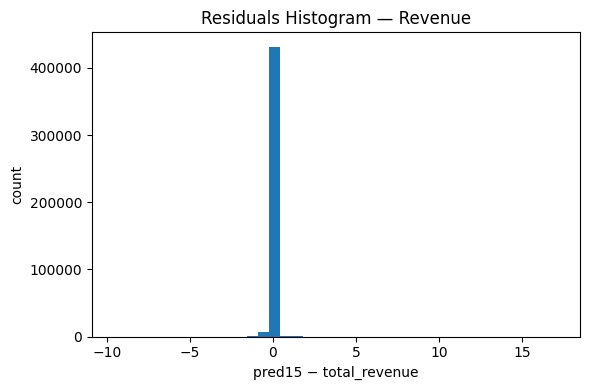

In [14]:
# Histograms of residuals (via pandas)
res_pd = res.select("residual").toPandas()

plt.figure(figsize=(6,4))
plt.hist(res_pd.residual, bins=40)
plt.title("Residuals Histogram — Revenue")
plt.xlabel("pred15 − total_revenue")
plt.ylabel("count")
plt.tight_layout()
plt.show()